# Breast Cancer Detection 

The notebook implements K Nearest Neighbor and Support Vector Machine on the Wisconsin Breast Cancer Dataset.

Thanks very much for the data preprocessing tutorial at http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial4/tutorial4.html.

## Importing data

In [60]:
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
names = ['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
       'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
df = pd.read_csv(url, names=names)

In [62]:
df.tail(10)

,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
689,654546,1,1,1,1,2,1,1,1,8,2
690,654546,1,1,1,3,2,1,1,1,1,2
691,695091,5,10,10,5,4,5,4,4,1,4
692,714039,3,1,1,1,2,1,1,1,1,2
693,763235,3,1,1,1,2,1,2,1,2,2
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4
698,897471,4,8,8,5,4,5,10,4,1,4


## Missing Values

According to the data description https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original), the missing values are encoded as ?

In [63]:
# Preprocess the data

df = df.replace('?',np.NaN)

print('Number of instances = %d' % (df.shape[0]))
print('Number of attributes = %d' % (df.shape[1]))

print('Number of missing values:')
for col in df.columns:
    print('\t%s: %d' % (col, df[col].isna().sum()))


Number of instances = 699
Number of attributes = 11
Number of missing values:
	id: 0
	clump_thickness: 0
	uniform_cell_size: 0
	uniform_cell_shape: 0
	marginal_adhesion: 0
	single_epithelial_size: 0
	bare_nuclei: 16
	bland_chromatin: 0
	normal_nucleoli: 0
	mitoses: 0
	class: 0


Note that only **bare_nuclei** contains missing values.

In [64]:
#df_imputed = df['bare_nuclei'].fillna(df['bare_nuclei'].median()) 
df.fillna(df['bare_nuclei'].median(), inplace=True)


In [65]:
print('Number of missing values:')
for col in df.columns:
    print('\t%s: %d' % (col, df[col].isna().sum()))


Number of missing values:
	id: 0
	clump_thickness: 0
	uniform_cell_size: 0
	uniform_cell_shape: 0
	marginal_adhesion: 0
	single_epithelial_size: 0
	bare_nuclei: 0
	bland_chromatin: 0
	normal_nucleoli: 0
	mitoses: 0
	class: 0


## Outliers
Boxplots are effective in identifying outliers.


In [66]:
# Describe the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      699 non-null    int64 
 1   clump_thickness         699 non-null    int64 
 2   uniform_cell_size       699 non-null    int64 
 3   uniform_cell_shape      699 non-null    int64 
 4   marginal_adhesion       699 non-null    int64 
 5   single_epithelial_size  699 non-null    int64 
 6   bare_nuclei             699 non-null    object
 7   bland_chromatin         699 non-null    int64 
 8   normal_nucleoli         699 non-null    int64 
 9   mitoses                 699 non-null    int64 
 10  class                   699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


Note that **bare_nuclei** is the only column where data is stored as string objects. Hence we would need to convert the column into numerical values before data analysis.

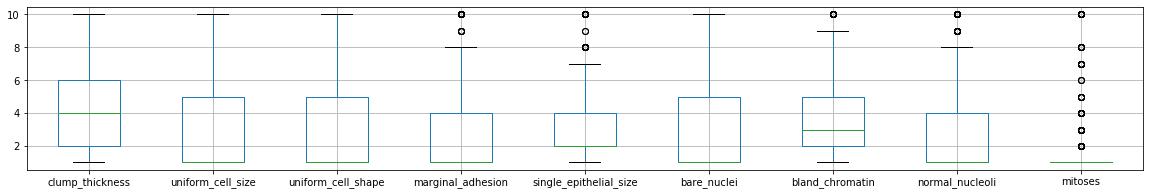

In [67]:
%matplotlib inline

df_new = df.drop(['class','id'],axis=1)
df_new['bare_nuclei'] = pd.to_numeric(df_new['bare_nuclei'])
df_new.boxplot(figsize=(20,3))

The plots suggest that the columns **marginal_adhesion, single_epithelial_size, bland_chromatin, normal_nucleoli, mitoses** contain outliers.

To deal with the outliers, we can compute z-scores for each attribute and remove the instances with z score greater than 3 or less than -3.

In [68]:
#from scipy import stats
#df['z_score']=stats.zscore(df['data'])
df_std = (df_new-df_new.mean())/df_new.std()

# (df_std > -3) returns Boolean data frame that indicates whether if > -3, then 1; else, then 0
# ((df_std > -3).sum(axis=1)==9) indicate rows with no z score less than -3
# ((df_std <= 3).sum(axis=1)==9)  indicates rows with no z score greater than 3
df = df.loc[((df_std > -3).sum(axis=1)==9) & ((df_std <= 3).sum(axis=1)==9),:]

## Duplicatication

Now we can check if we contain duplicate data.

In [69]:
# The duplicated() function will return a Boolean array that indicates whether each row is a duplicate of a previous row in the table. 
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))


Number of duplicate rows = 7


In [70]:
df = df.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (df.shape[0]))

Number of rows after discarding duplicates = 641


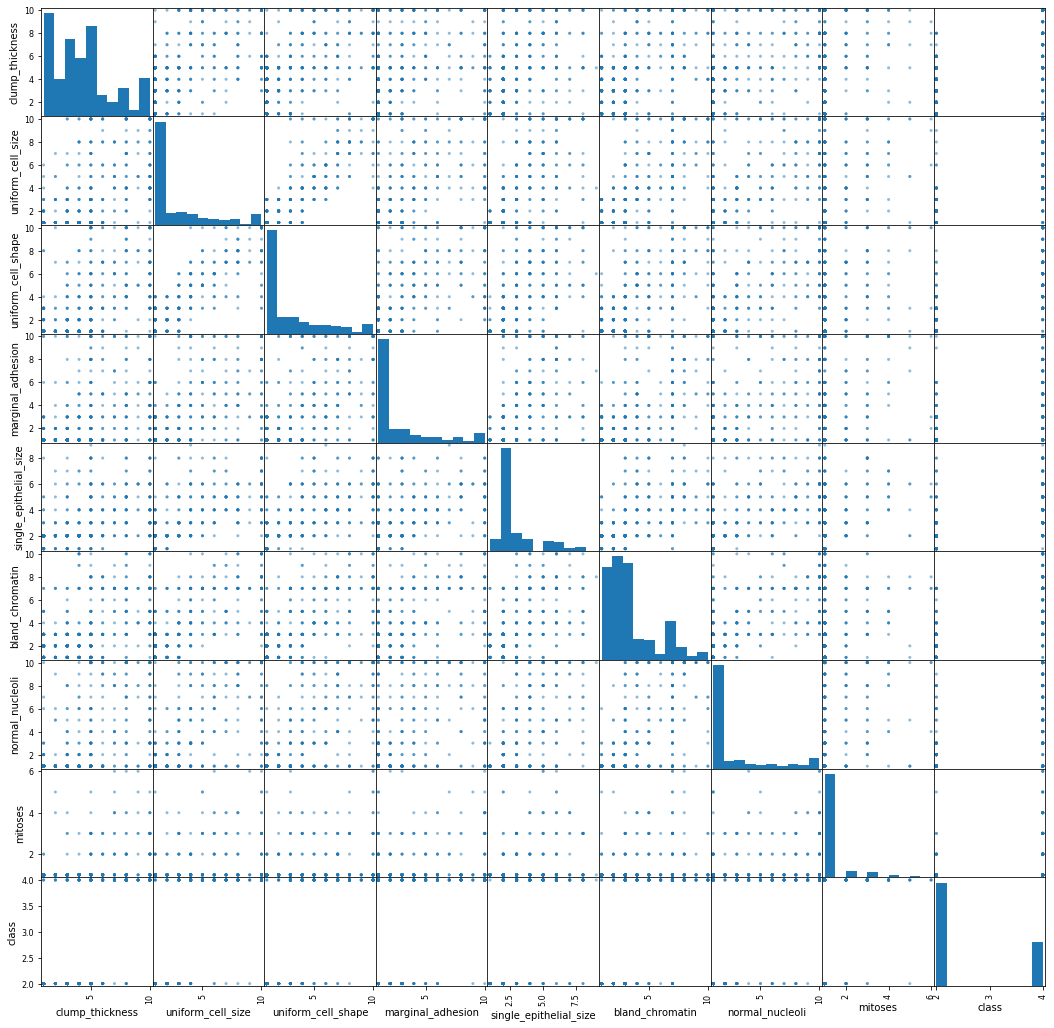

In [71]:
df = df.drop('id', axis=1)
# Create scatter plot matrix
scatter_matrix(df, figsize = (18,18))
plt.show()

## Model Building

In [72]:
# Create X and Y datasets for training
X = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [73]:
# Testing Options
seed = 8
scoring = 'accuracy'

In [74]:
# Define models to train
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5)))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state = None)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.966780 (0.012563)
SVM: 0.960897 (0.026336)


In [75]:

# Make predictions on validation dataset

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    
# Accuracy - ratio of correctly predicted observation to the total observations. 
# Precision - (false positives) ratio of correctly predicted positive observations to the total predicted positive observations
# Recall (Sensitivity) - (false negatives) ratio of correctly predicted positive observations to the all observations in actual class - yes.
# F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false

KNN
0.9767441860465116
              precision    recall  f1-score   support

           2       1.00      0.97      0.98        90
           4       0.93      1.00      0.96        39

    accuracy                           0.98       129
   macro avg       0.96      0.98      0.97       129
weighted avg       0.98      0.98      0.98       129

SVM
0.9689922480620154
              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.91      1.00      0.95        39

    accuracy                           0.97       129
   macro avg       0.95      0.98      0.96       129
weighted avg       0.97      0.97      0.97       129



In [76]:
clf = SVC()

clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

example_measures = np.array([[4,2,1,1,1,2,3,2,1]])
example_measures = example_measures.reshape(len(example_measures), -1)
prediction = clf.predict(example_measures)
print(prediction)

0.9689922480620154
[2]


We see that both the KNN and the support vector machine performs really well for this task!